In [1]:
%matplotlib inline


# Benchmark over-sampling and under-sampling methods in imbalance classification tasks


In those imbalance classification example four imbalanced datasets (ecoli, sick_euthyroid, yeast_ml8 and thyroid_sick) are used. 
Several implemented over-sampling and under-sampling
methods are used in conjunction with a 3NN classifier in order
to examine the improvement of the classifier's output quality
by using over-sampler and under-sampler.

Automatically created module for IPython interactive environment
Counts of ecoli dataset:  [(-1, 301), (1, 35)]


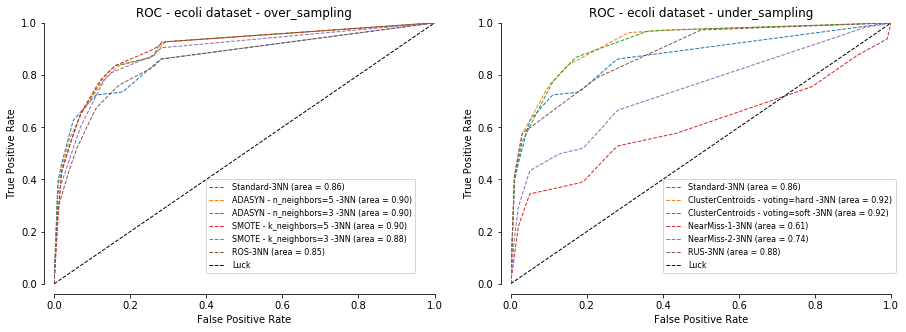

Counts of sick_euthyroid dataset:  [(-1, 2870), (1, 293)]


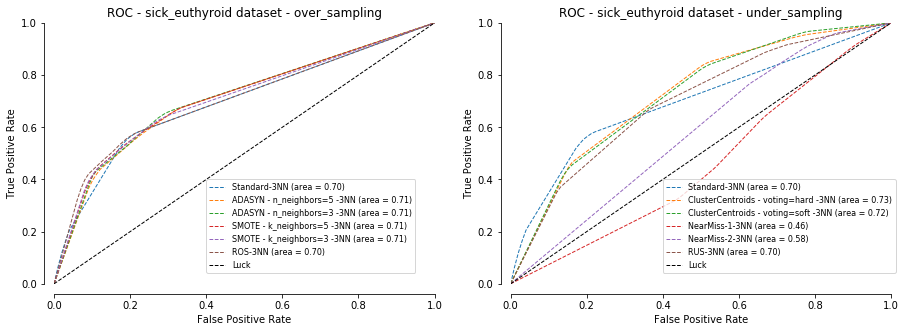

Counts of yeast_ml8 dataset:  [(-1, 2239), (1, 178)]


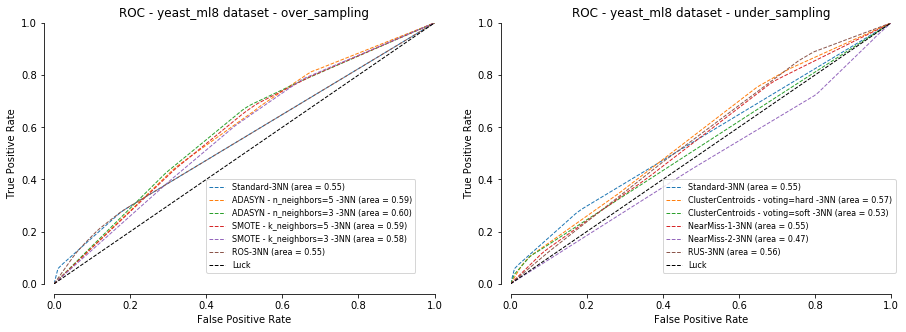

Counts of thyroid_sick dataset:  [(-1, 3541), (1, 231)]


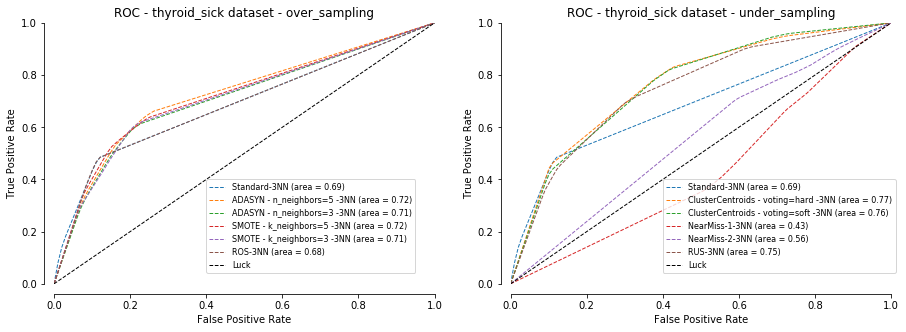

In [2]:
# https://github.com/hkthirano/class/blob/master/plot_over_sampling_benchmark_lfw.ipynb

# Authors: Christos Aridas
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT
# https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/applications/plot_over_sampling_benchmark_lfw.html#sphx-glr-auto-examples-applications-plot-over-sampling-benchmark-lfw-py

import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from sklearn import datasets, neighbors
from imblearn.datasets import fetch_datasets
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from statistics import mean

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline

print(__doc__)

LW = 1
RANDOM_STATE = 42


class DummySampler:

    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_resample(self, X, y):
        return self.sample(X, y)


cv = StratifiedKFold(n_splits=3)

# Load the dataset
# data = datasets.fetch_lfw_people()
# majority_person = 1871  # 530 photos of George W Bush
# minority_person = 531  # 29 photos of Bill Clinton
# majority_idxs = np.flatnonzero(data.target == majority_person)
# minority_idxs = np.flatnonzero(data.target == minority_person)
# idxs = np.hstack((majority_idxs, minority_idxs))

classifier = ['3NN', neighbors.KNeighborsClassifier(3)]

over_samplers = [
    ['Standard', DummySampler()],
    ['ADASYN - n_neighbors=5 ', ADASYN(random_state=RANDOM_STATE)],
    ['ADASYN - n_neighbors=3 ', ADASYN(random_state=RANDOM_STATE, n_neighbors=3)],
    ['SMOTE - k_neighbors=5 ', SMOTE(random_state=RANDOM_STATE)],
    ['SMOTE - k_neighbors=3 ', SMOTE(random_state=RANDOM_STATE, k_neighbors=3)],
    ['ROS', RandomOverSampler(random_state=RANDOM_STATE)],
]

under_samplers = [
    ['Standard', DummySampler()],
    ['ClusterCentroids - voting=hard ', ClusterCentroids(random_state=RANDOM_STATE, voting='hard')],
    ['ClusterCentroids - voting=soft ', ClusterCentroids(random_state=RANDOM_STATE, voting='soft')],
    ['NearMiss-1', NearMiss(version=1)],
    ['NearMiss-2', NearMiss(version=2)],
    ['RUS', RandomUnderSampler(random_state=RANDOM_STATE)]
]

samplers_list = [over_samplers, under_samplers]
samplers_name = ['over_sampling', 'under_sampling']

dataset_list = ['ecoli', 'sick_euthyroid', 'yeast_ml8', 'thyroid_sick']

for dataset_name in dataset_list:
    data = fetch_datasets()[dataset_name]
    X = data.data
    y = data.target
    y = np.where(y==-1, 0, y)
    print('Counts of {} dataset: '.format(dataset_name), sorted(Counter(data.target).items()))

    fig = plt.figure(figsize=(15, 4.8))

    for i, samplers in enumerate(samplers_list):
        ax = fig.add_subplot(1, 2, i+1)
        pipelines = [
            ['{}-{}'.format(sampler[0], classifier[0]),
            make_pipeline(sampler[1], classifier[1])]
            for sampler in samplers
        ]

        for name, pipeline in pipelines:
            mean_tpr = 0.0
            mean_fpr = np.linspace(0, 1, 100)
            cv_nb = 0
            for train, test in cv.split(X, y):
                probas_ = pipeline.fit(X[train], y[train]).predict_proba(X[test])
                fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
                mean_tpr += interp(mean_fpr, fpr, tpr)
                mean_tpr[0] = 0.0
                roc_auc = auc(fpr, tpr)

            mean_tpr /= cv.get_n_splits(X, y)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, linestyle='--',
                    label='{} (area = %0.2f)'.format(name) % mean_auc, lw=LW)

        plt.plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k',
                label='Luck')

        # make nice plotting
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        ax.set_title('ROC - {} dataset - {}'.format(dataset_name, samplers_name[i]))

        ax.legend(bbox_to_anchor=(0.4, 0.4), loc='upper left', borderaxespad=0, fontsize=8)

    plt.show()